In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.inspection import PartialDependenceDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# Gradient Boosting Regressors
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
X_train = pd.read_csv('X_train.csv',index_col='Id')
X_valid = pd.read_csv('X_valid.csv',index_col='Id')
y_train = pd.read_csv('y_train.csv',index_col='Id')
y_valid = pd.read_csv('y_valid.csv',index_col='Id')

## Basic Linear Regression as a Baseline
We'll start by training a simple Linear Regression model as our baseline.

In [3]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Instantiate the Linear Regression model
lin_reg = LinearRegression()
# Define the scoring metrics
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

# Perform cross-validation
cv_results_lin = cross_validate(lin_reg, X_train, y_train, cv=5, scoring=scoring)

# Calculate average scores
mean_mae = -cv_results_lin['test_MAE'].mean()
mean_rmse = -cv_results_lin['test_RMSE'].mean()
mean_r2 = cv_results_lin['test_R2'].mean()

print('Linear Regression Cross-Validation Results:')
print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean R²: {mean_r2:.2f}")


Linear Regression Cross-Validation Results:
Mean MAE: 22063.26
Mean RMSE: 36259.76
Mean R²: 0.77


Those results are actually not too bad, let's see if we can do better with more advanced techniques

## Advanced Models
Now lets make it interesting! We will examine the performance of various models on our dataset.

In [4]:
# Instantiate the Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
# Perform cross-validation
cv_results_rf = cross_validate(rf_reg, X_train, y_train.values.ravel(), cv=5, scoring=scoring, n_jobs=-1)

# Calculate average scores
mean_mae_rf = -cv_results_rf['test_MAE'].mean()
mean_rmse_rf = -cv_results_rf['test_RMSE'].mean()
mean_r2_rf = cv_results_rf['test_R2'].mean()

print('Random Forest Cross-Validation Results:')
print(f"Mean MAE: {mean_mae_rf:.2f}")
print(f"Mean RMSE: {mean_rmse_rf:.2f}")
print(f"Mean R²: {mean_r2_rf:.2f}")


Random Forest Cross-Validation Results:
Mean MAE: 18595.17
Mean RMSE: 30940.87
Mean R²: 0.83


This is far far better, which is great! It means we aren't adding complexity for nothing! Lets see if XGBoost is even better.

In [5]:
# Instantiate the XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42, verbosity=0)
# Perform cross-validation
cv_results_xgb = cross_validate(xgb_reg, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

# Calculate average scores
mean_mae_xgb = -cv_results_xgb['test_MAE'].mean()
mean_rmse_xgb = -cv_results_xgb['test_RMSE'].mean()
mean_r2_xgb = cv_results_xgb['test_R2'].mean()

print('XGBoost Cross-Validation Results:')
print(f"Mean MAE: {mean_mae_xgb:.2f}")
print(f"Mean RMSE: {mean_rmse_xgb:.2f}")
print(f"Mean R²: {mean_r2_xgb:.2f}")


XGBoost Cross-Validation Results:
Mean MAE: 19052.28
Mean RMSE: 32294.12
Mean R²: 0.82


In [6]:
# Instantiate the CatBoost Regressor
catboost_reg = CatBoostRegressor(random_state=42, verbose=0)
# Perform cross-validation
cv_results_cat = cross_validate(catboost_reg, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

# Calculate average scores
mean_mae_cat = -cv_results_cat['test_MAE'].mean()
mean_rmse_cat = -cv_results_cat['test_RMSE'].mean()
mean_r2_cat = cv_results_cat['test_R2'].mean()

print('CatBoost Cross-Validation Results:')
print(f"Mean MAE: {mean_mae_cat:.2f}")
print(f"Mean RMSE: {mean_rmse_cat:.2f}")
print(f"Mean R²: {mean_r2_cat:.2f}")


CatBoost Cross-Validation Results:
Mean MAE: 16641.17
Mean RMSE: 28536.04
Mean R²: 0.86


In [7]:

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost'],
    'MAE': [mean_mae, mean_mae_rf, mean_mae_xgb, mean_mae_cat],
    'RMSE': [mean_rmse, mean_rmse_rf, mean_rmse_xgb, mean_rmse_cat],
    'R²': [mean_r2, mean_r2_rf, mean_r2_xgb, mean_rmse_cat]
})

results


,Model,MAE,RMSE,R²
0,Linear Regression,22063.258428,36259.757982,0.774866
1,Random Forest,18595.173096,30940.868799,0.833939
2,XGBoost,19052.278154,32294.124364,0.820471
3,CatBoost,16641.168787,28536.035326,28536.035326


So Random Forest appears to perform the best based off of these metrics. Lets explore both random forest and XGBoost with some hyperparameter tuning and see how far we can push those scores down


In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid centered around default values
param_dist_rf = {
    'n_estimators': [80, 100, 120],
    'max_depth': [None, 10, 20],
    'max_features': [None, 'sqrt', 'log2'],  # Replaced 'auto' with None
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Instantiate the Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)

# Perform Randomized Search CV
random_search_rf = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_dist_rf,
    n_iter=20,                  # Increased iterations for better search
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search_rf.fit(X_train, y_train.values.ravel())

# Output the best parameters and score
print("Best parameters for Random Forest:")
print(random_search_rf.best_params_)
print(f"Best MAE score: {-random_search_rf.best_score_:.2f}")



Best parameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best MAE score: 17682.97


In [9]:
# Define the parameter grid
param_dist_xgb = {
    'n_estimators': [100, 200, 500, 100],
    'max_depth': [3, 5, 7, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
}

# Instantiate the XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42, verbosity=0)

# Perform Randomized Search CV
random_search_xgb = RandomizedSearchCV(
    xgb_reg, param_distributions=param_dist_xgb, n_iter=10, cv=5,
    scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)

random_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:")
print(random_search_xgb.best_params_)
print(f"Best MAE score: {-random_search_xgb.best_score_:.2f}")


Best parameters for XGBoost:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best MAE score: 17426.84


In [10]:
# Define the parameter grid
param_dist_cat = {
    'iterations': [100, 200, 500, 1000],
    'depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Instantiate the CatBoost Regressor
catboost_reg = CatBoostRegressor(random_state=42, verbose=0)

# Perform Randomized Search CV
random_search_cat = RandomizedSearchCV(
    catboost_reg, param_distributions=param_dist_cat, n_iter=10, cv=5,
    scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)

random_search_cat.fit(X_train, y_train)

print("Best parameters for CatBoost:")
print(random_search_cat.best_params_)
print(f"Best MAE score: {-random_search_cat.best_score_:.2f}")


Best parameters for CatBoost:
{'learning_rate': 0.1, 'iterations': 200, 'depth': 6}
Best MAE score: 16806.92


Interesting, now they both converge on similar values. XGBoost appears to do a bit better on the MAE and RMSE overall

In [11]:
# List of best models after hyperparameter tuning
best_models = {
    'Random Forest': random_search_rf.best_estimator_,
    'XGBoost': random_search_xgb.best_estimator_,
    'CatBoost': random_search_cat.best_estimator_
}

# Dictionary to store evaluation metrics
evaluation_results = {}

for name, model in best_models.items():
    # Predict on validation data
    y_pred = model.predict(X_valid)
    # Calculate metrics
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = root_mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    # Store results
    evaluation_results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
    print(f'{name} Evaluation on Validation Set:')
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print('-----------------------------------')


Random Forest Evaluation on Validation Set:
MAE: 17166.90
RMSE: 28727.39
R²: 0.89
-----------------------------------
XGBoost Evaluation on Validation Set:
MAE: 16990.13
RMSE: 27007.61
R²: 0.90
-----------------------------------
CatBoost Evaluation on Validation Set:
MAE: 17553.02
RMSE: 27822.59
R²: 0.90
-----------------------------------


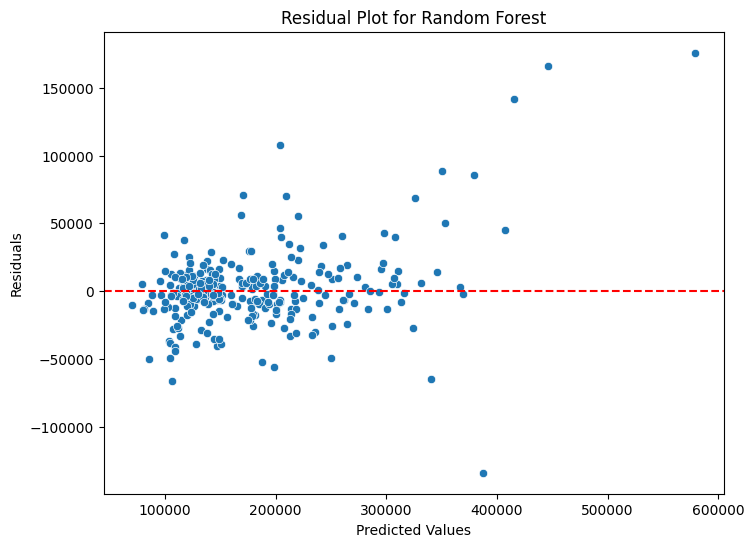

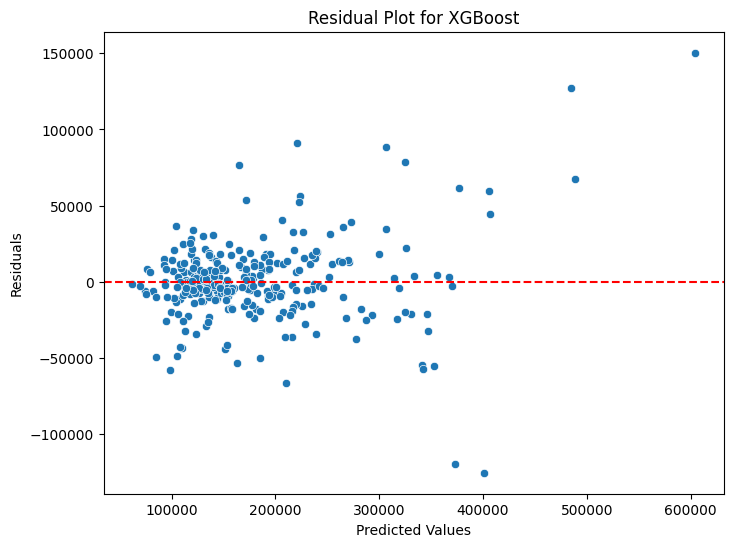

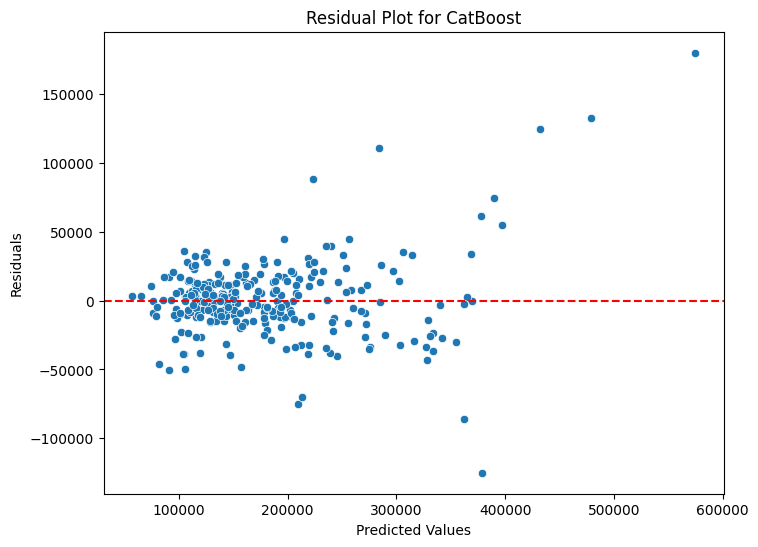

In [12]:
for name, model in best_models.items():
    # Predict values
    y_pred = model.predict(X_valid)

    # Create a DataFrame with predicted values and indices
    predictions = pd.DataFrame({
        'Predicted': y_pred
    }, index=X_valid.index)

    # Add actual values from y_valid, aligned by index
    predictions['Actual'] = y_valid['SalePrice']

    # Calculate residuals
    predictions['Residual'] = predictions['Actual'] - predictions['Predicted']
    # Plot residuals
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictions['Predicted'], y=predictions['Residual'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {name}')
    plt.show()
    predictions.to_csv("predictions.csv")




In [13]:
#Focusing on XGBoost
predictions.sort_values('Residual', inplace=True)
predictions.head()

,Predicted,Actual,Residual
Id,,,
582,378291.348312,253293,-124998.348312
262,362004.624125,276000,-86004.624125
629,209741.375116,135000,-74741.375116
589,212959.396724,143000,-69959.396724
31,90674.125000,40000,-50674.125000
